# Hamiltonian MCMC

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.plot
import pints.toy
import pints.cptests.hamiltonian_mcmc as hmc

from utils import run_replicates, ecdf_norm_plotter

parallel = True

# Two dimensional Gaussian

In [89]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 7000, 8), 10, hmc.two_dim_gaussian, parallel)
print(t.format())

4 minutes, 30 seconds


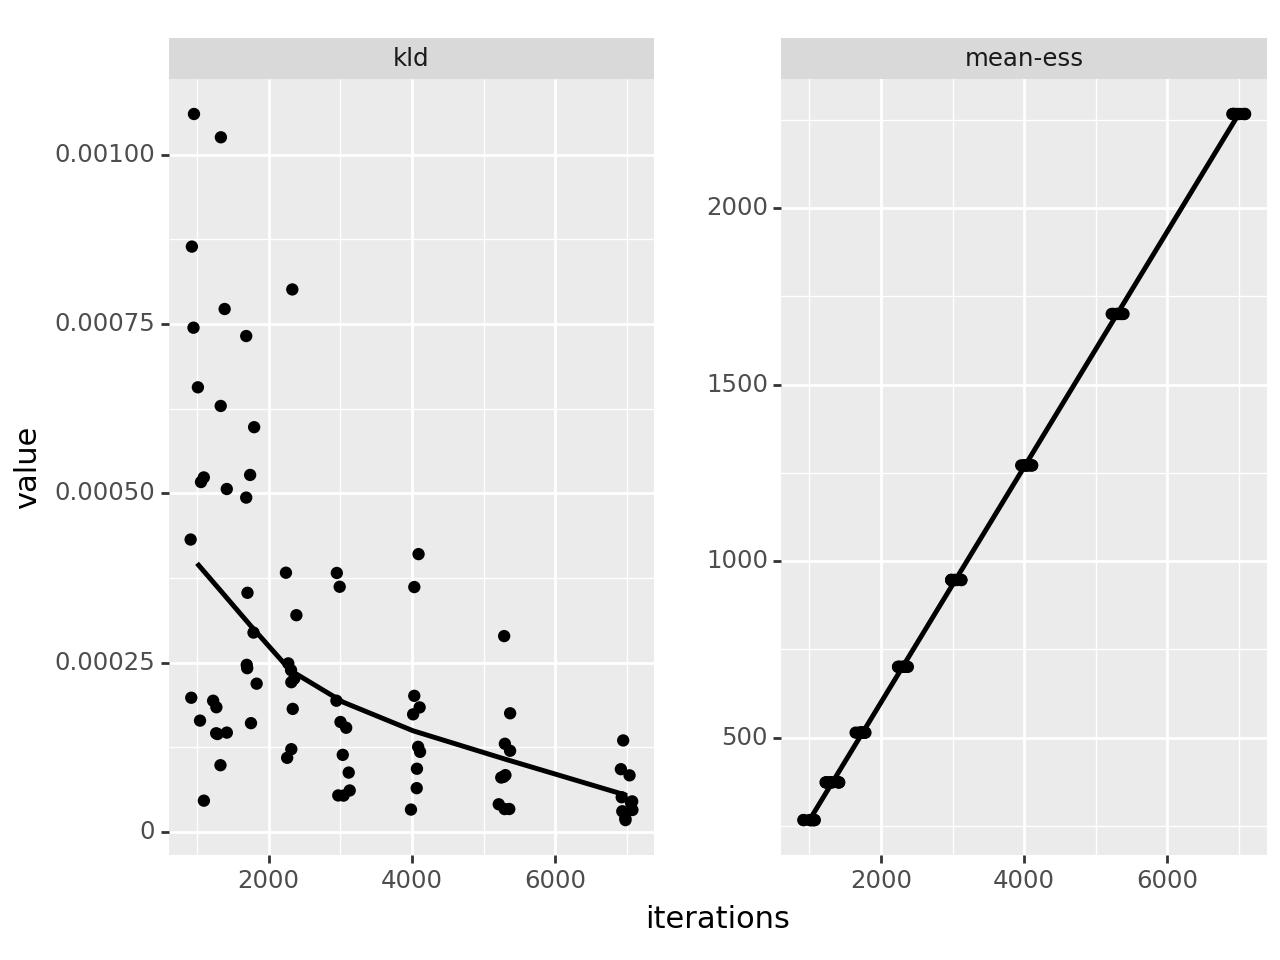

<Figure Size: (640 x 480)>

In [90]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

The ESS and KLD both trend in the correct directions.

Show example run results.

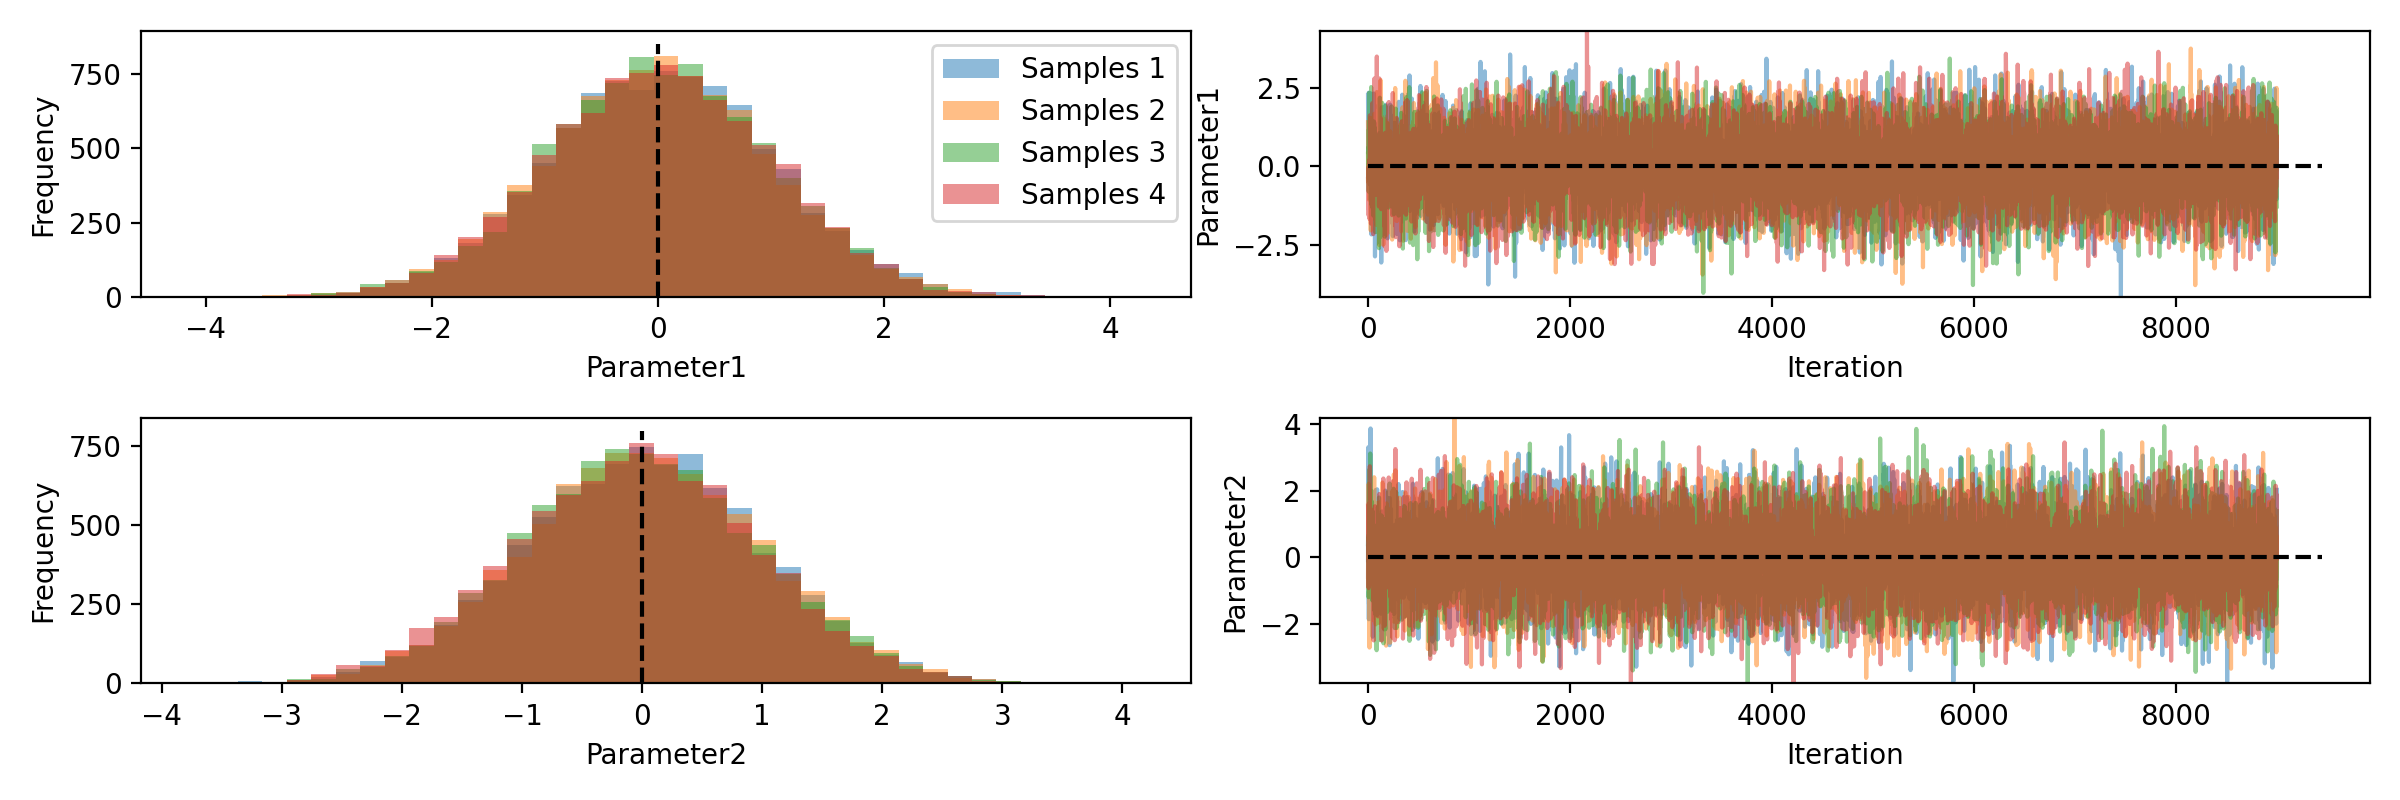

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  0.01    0.99    -1.94   -0.66  0.01   0.69   1.96     1.00    6495.92  83.07
param 2  -0.01   1.00    -1.97   -0.68  -0.01  0.66   1.96     1.00    6570.88  84.02


In [91]:
n_chains = 4
n_iterations = 10000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.HamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(0.5)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

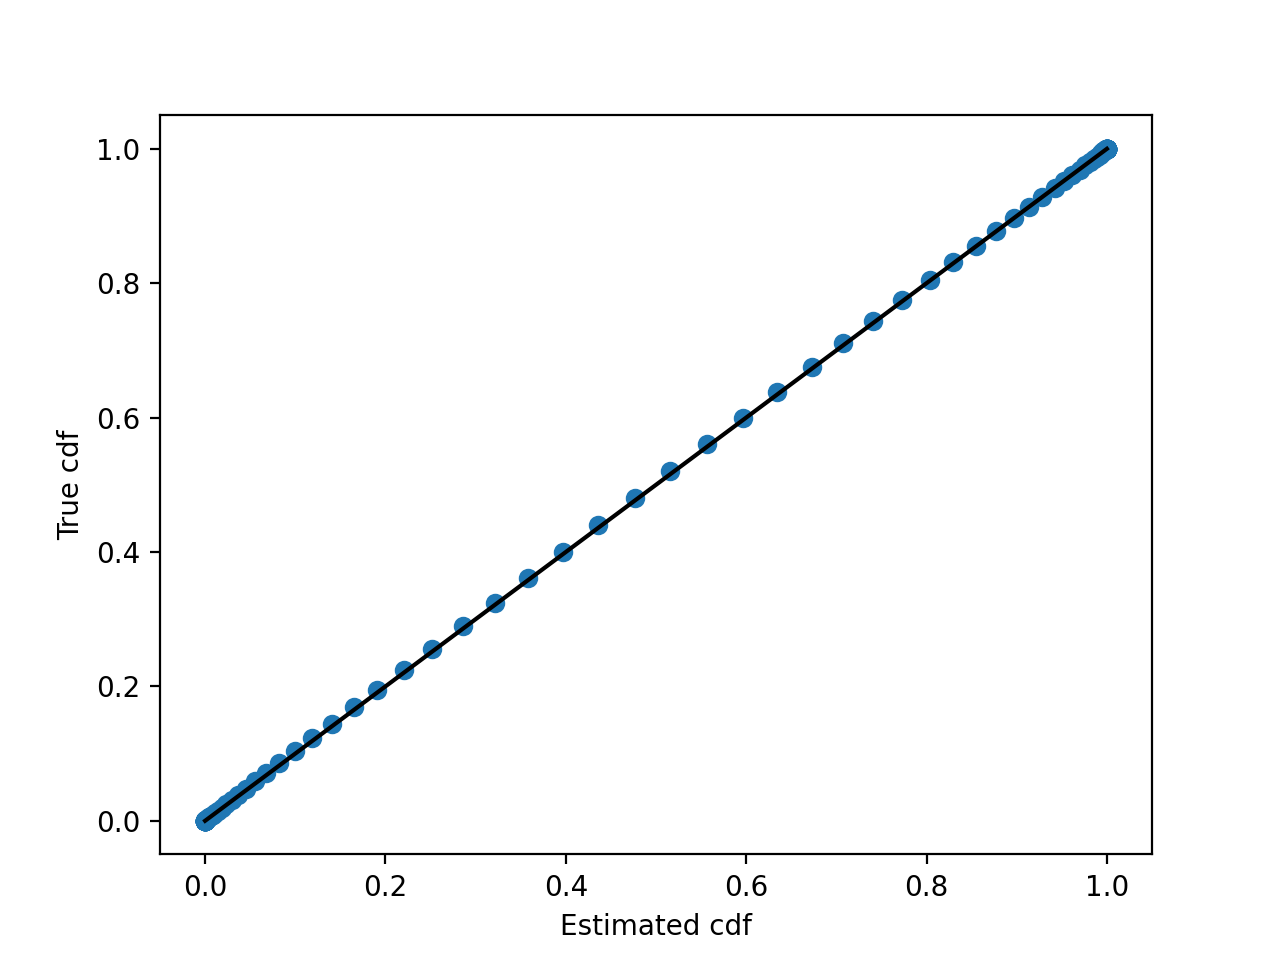

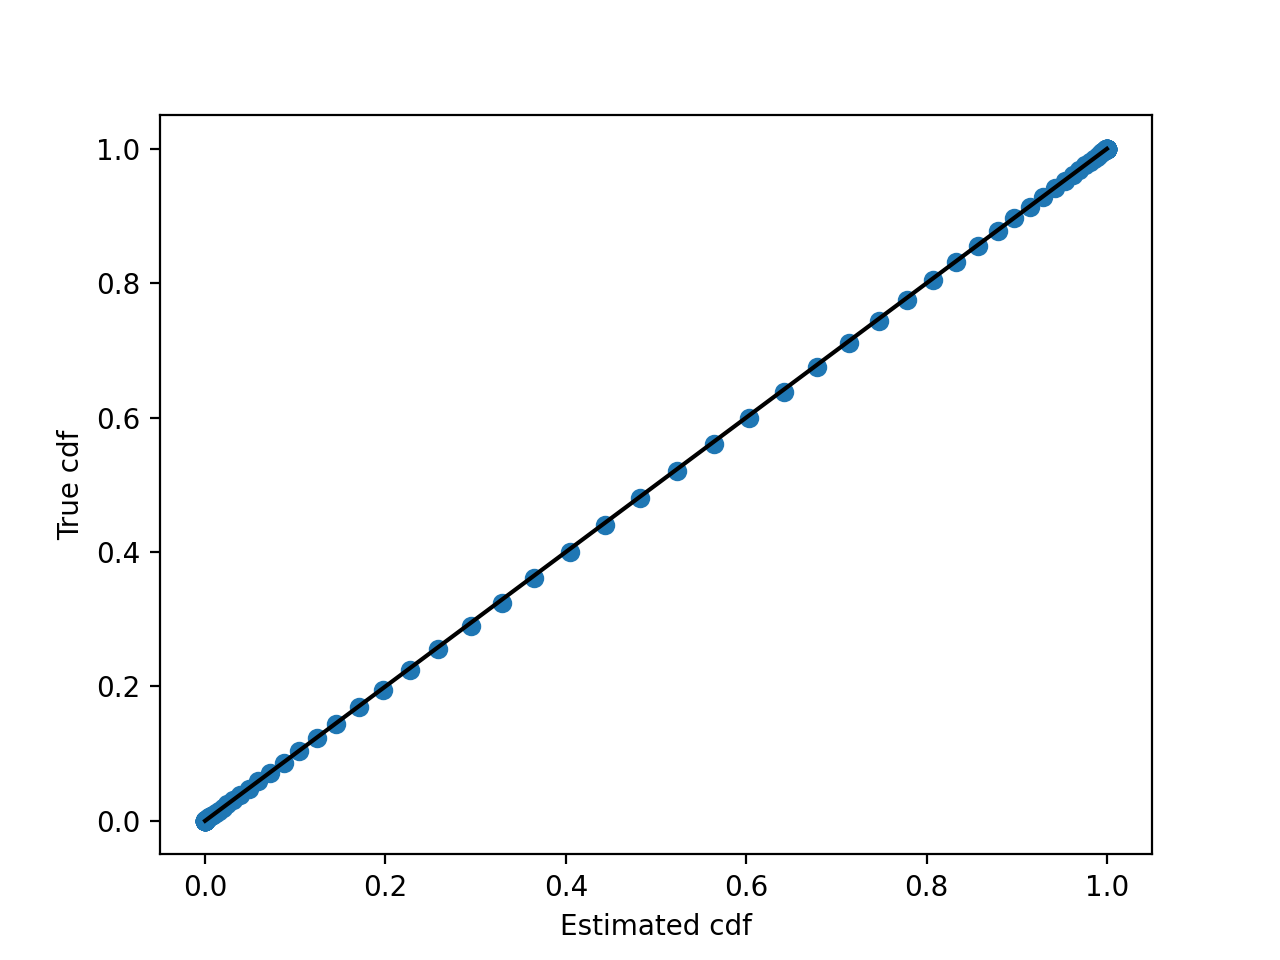

[None, None]

In [92]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [93]:
t = pints.Timer()
test = run_replicates(np.geomspace(2000, 10000, 8), 10, hmc.correlated_gaussian, parallel)
print(t.format())

6 minutes, 58 seconds


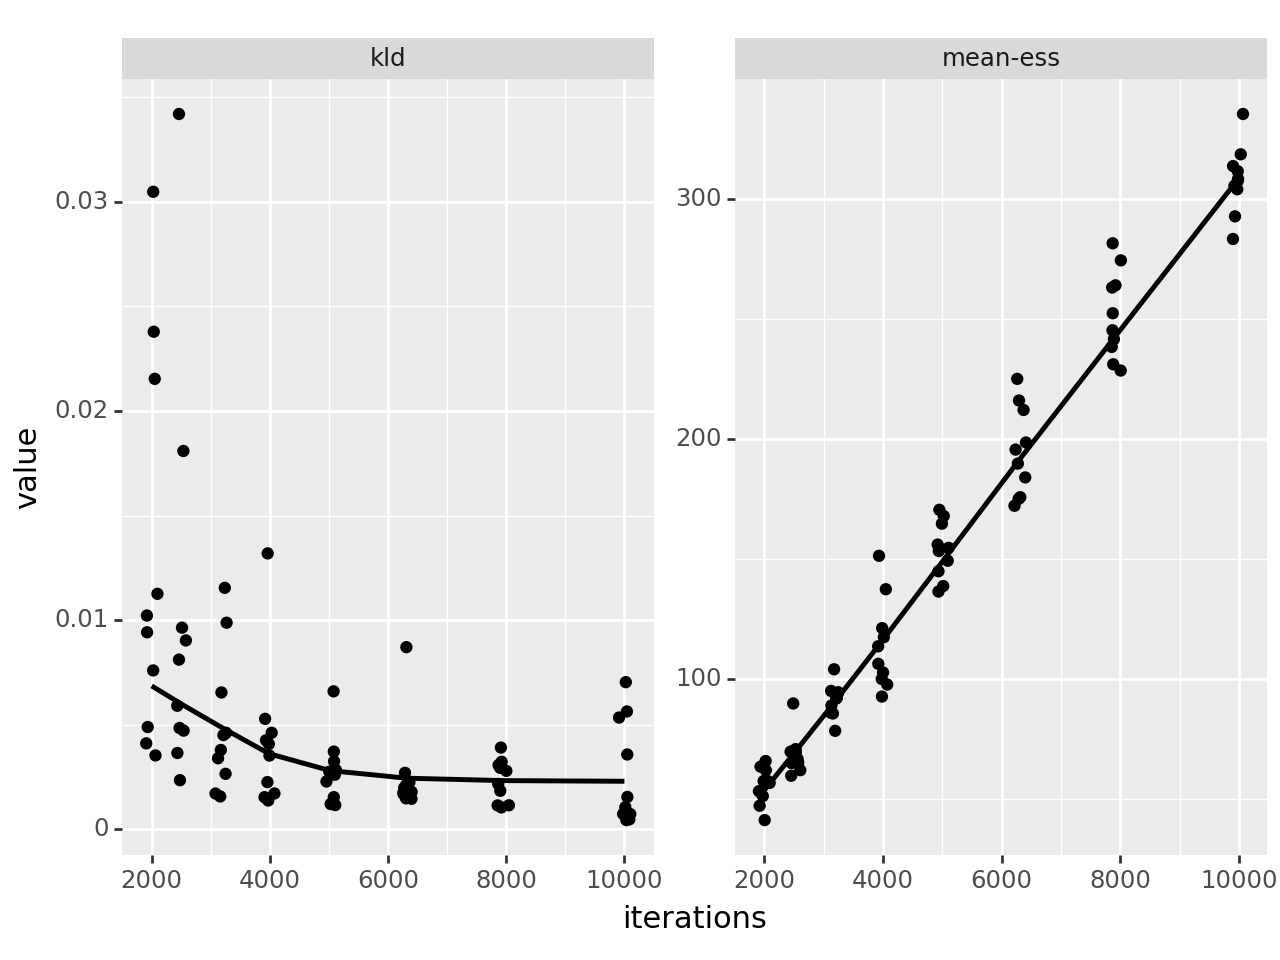

<Figure Size: (640 x 480)>

In [94]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free'))

Example run of results.

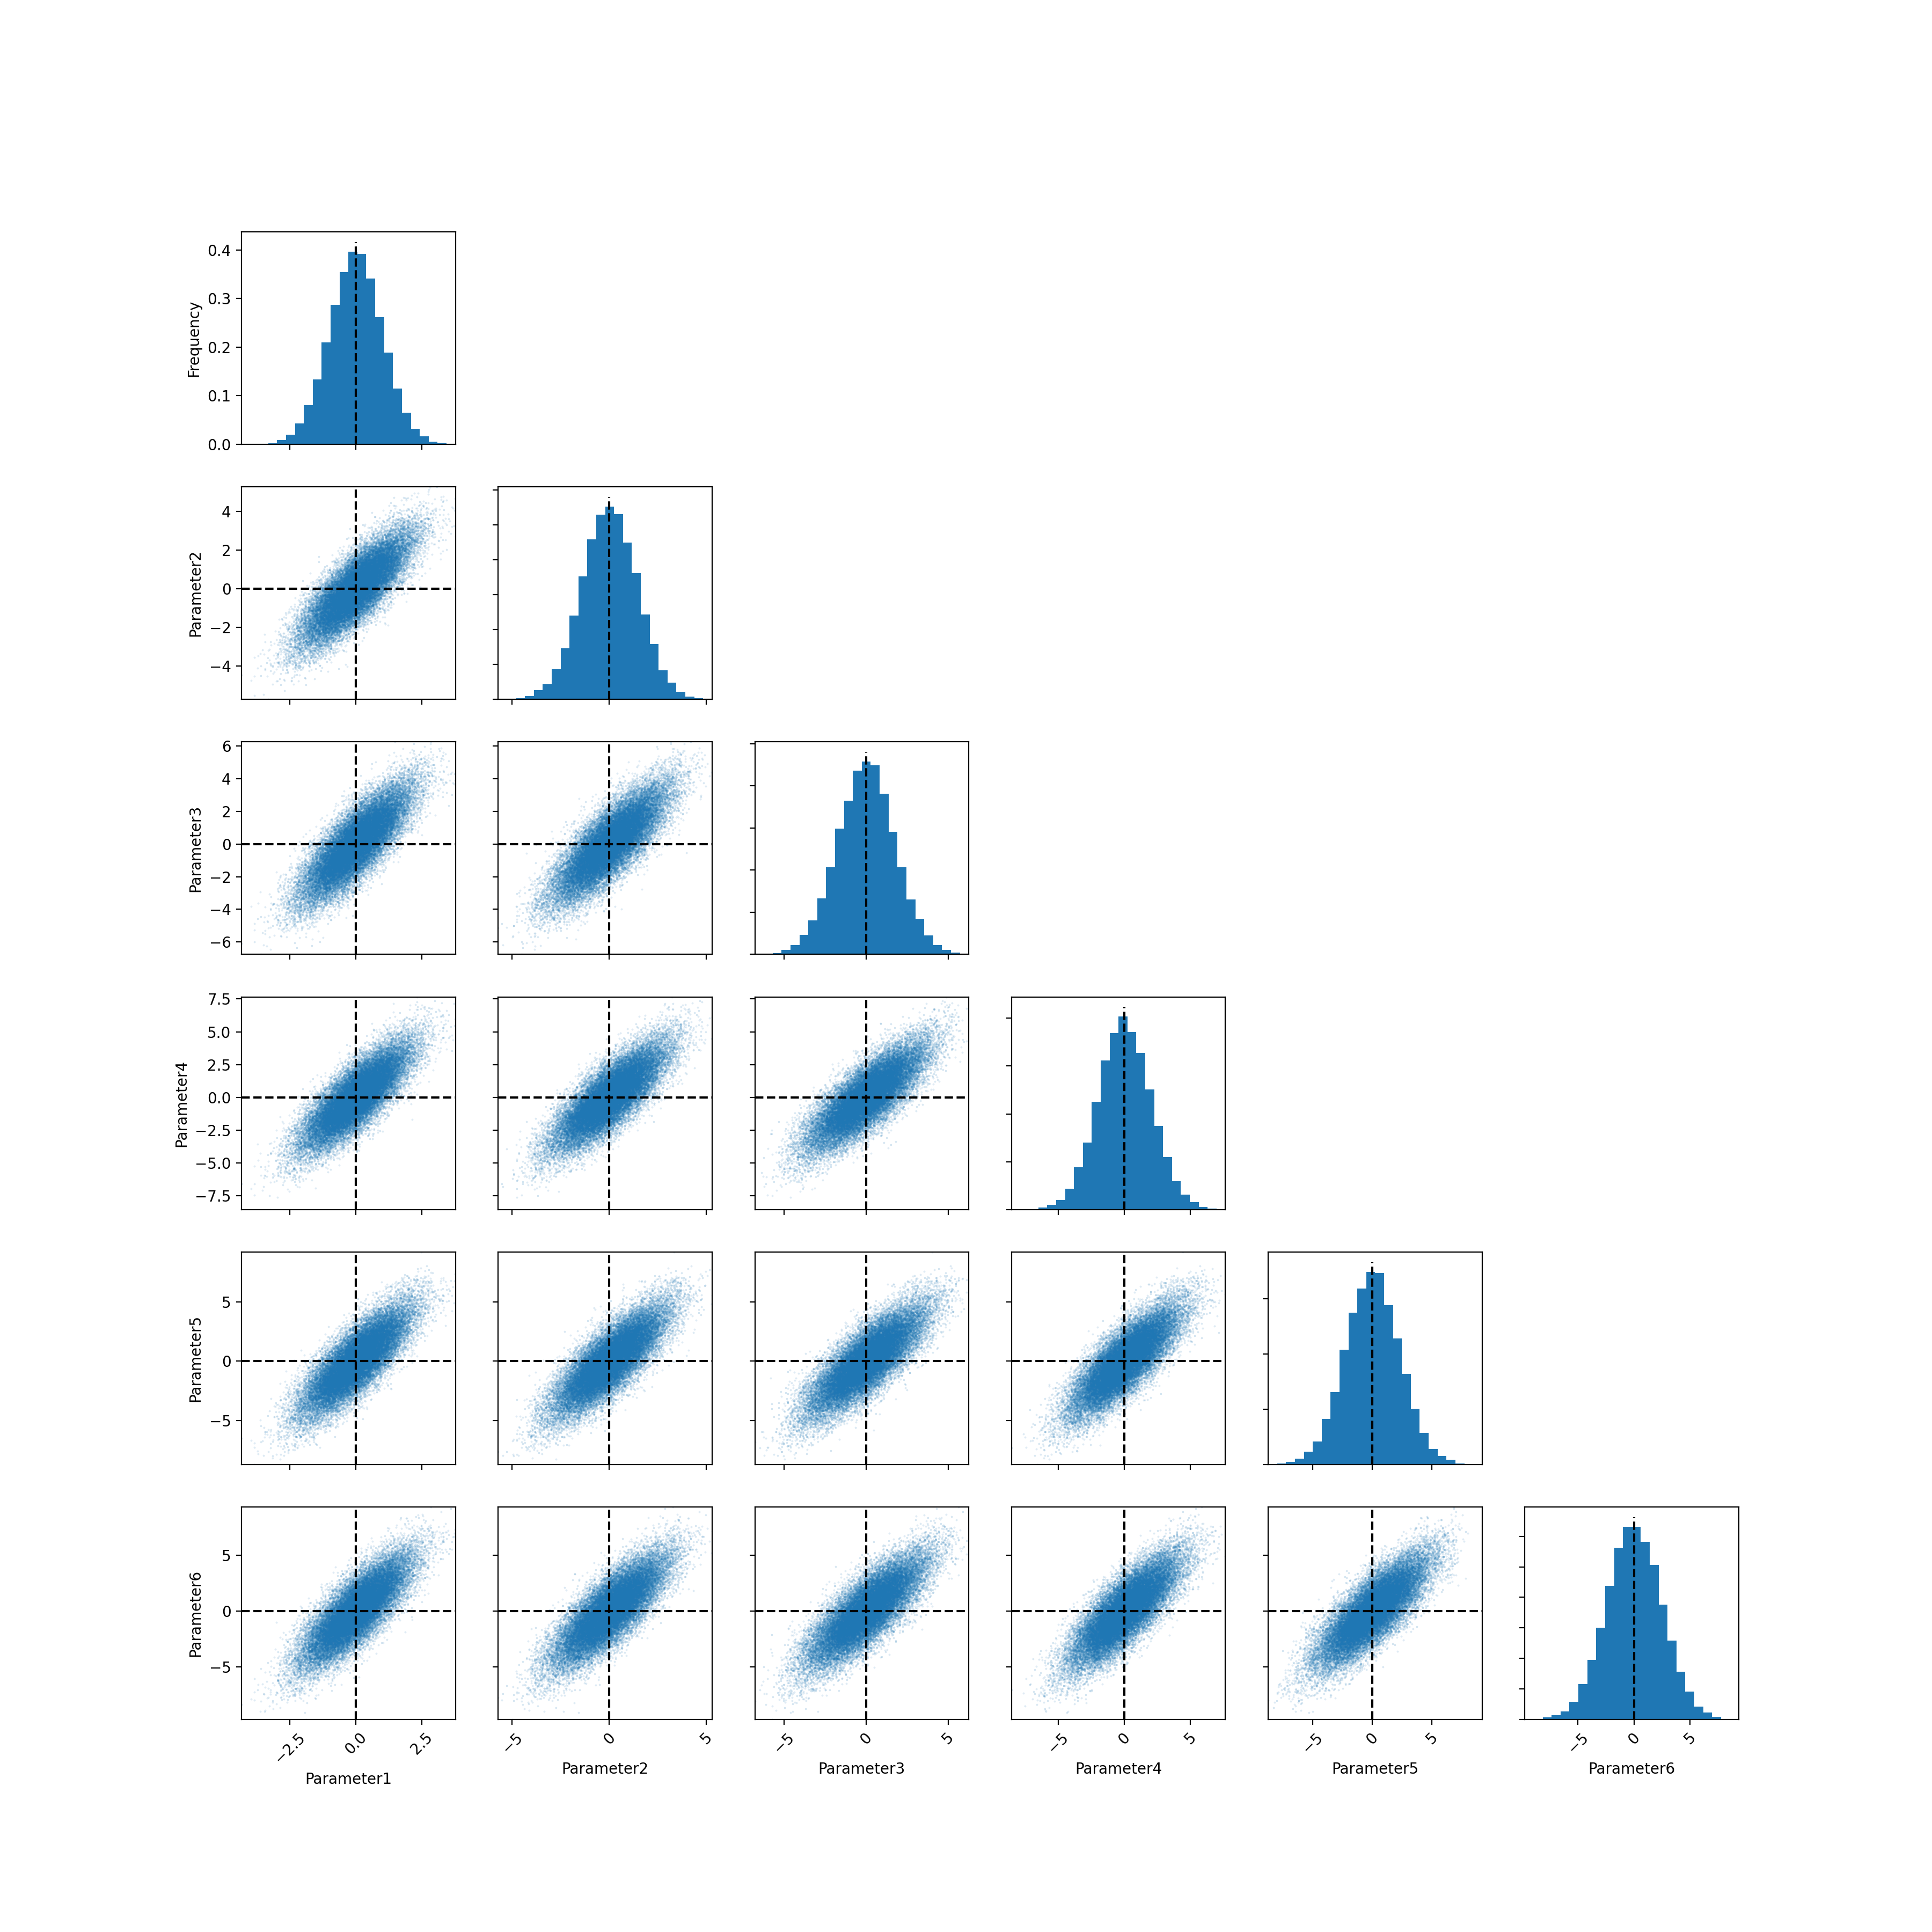

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.01    1.01    -1.97   -0.66  0.02   0.69   1.98     1.01    524.25  6.83
param 2  0.02    1.43    -2.79   -0.94  0.02   0.99   2.83     1.01    509.34  6.63
param 3  0.02    1.74    -3.42   -1.15  0.03   1.18   3.46     1.01    492.95  6.42
param 4  0.03    2.01    -3.86   -1.32  0.01   1.37   4.01     1.01    502.50  6.54
param 5  0.02    2.28    -4.48   -1.52  0.03   1.54   4.50     1.01    486.15  6.33
param 6  0.03    2.47    -4.79   -1.64  0.01   1.69   4.88     1.01    478.94  6.24


In [95]:
n_chains = 4
n_iterations = 10000
n_warmup = 2000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(0.5)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

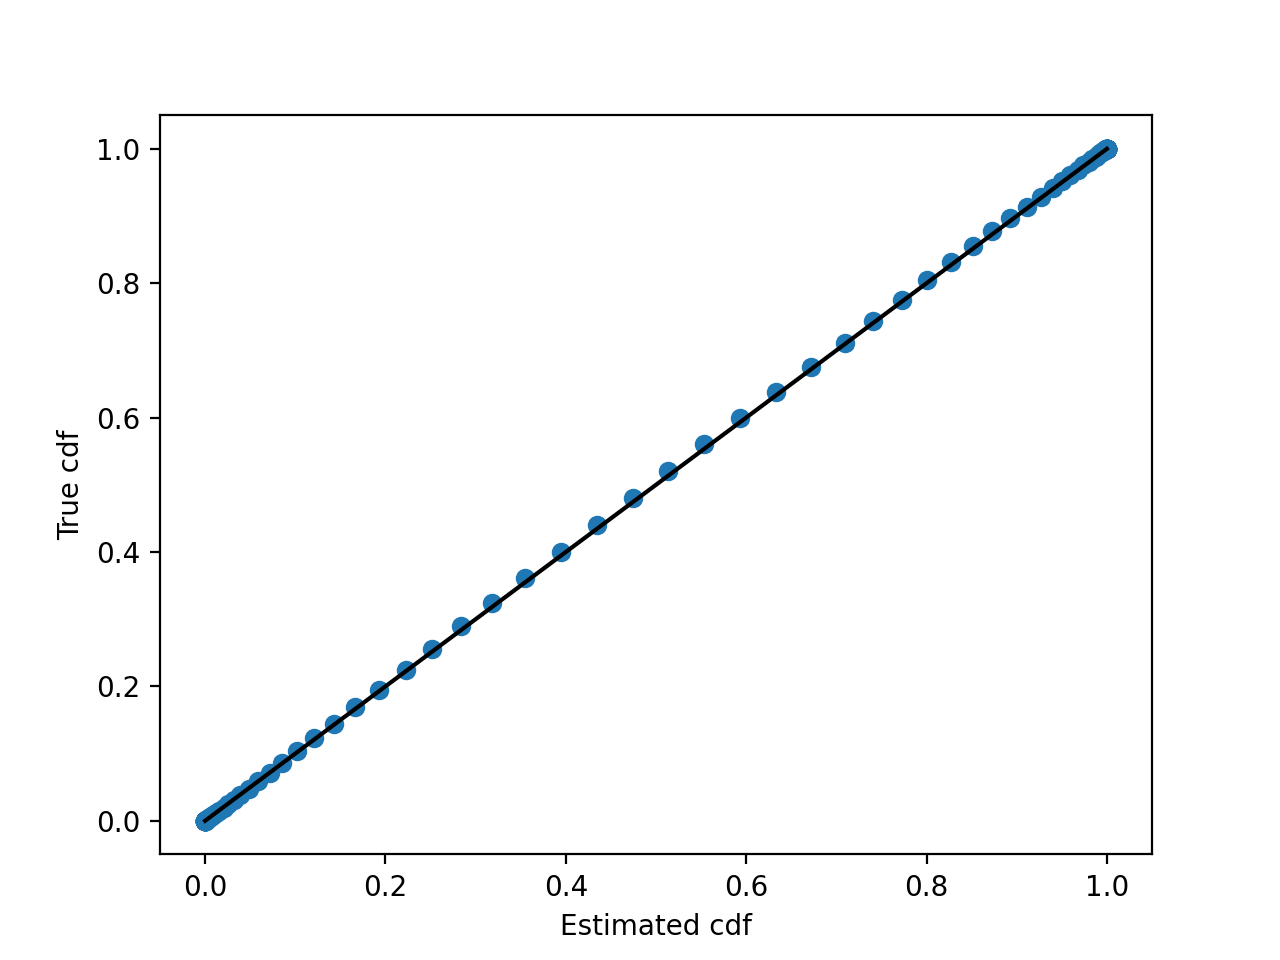

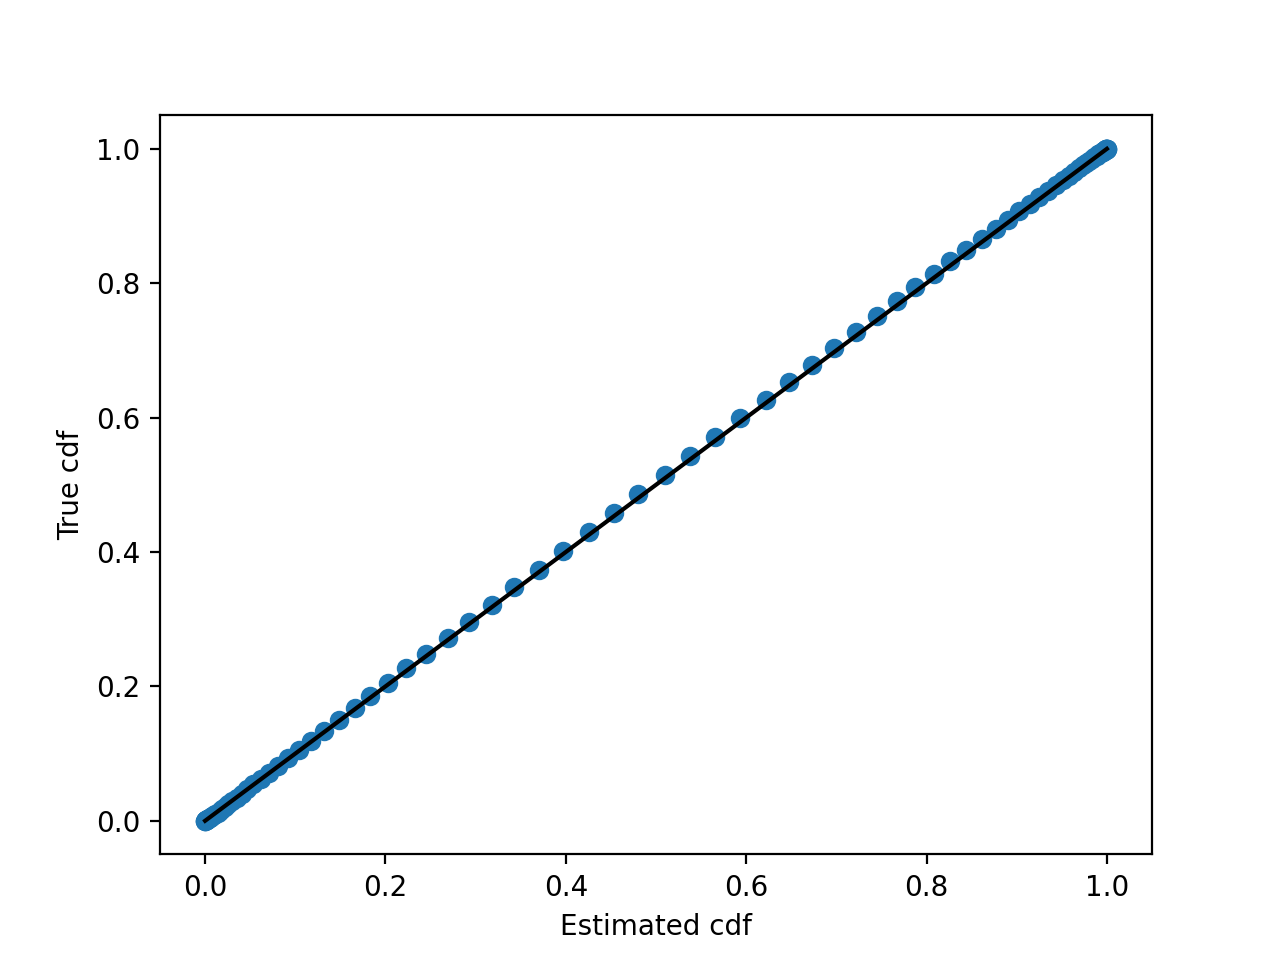

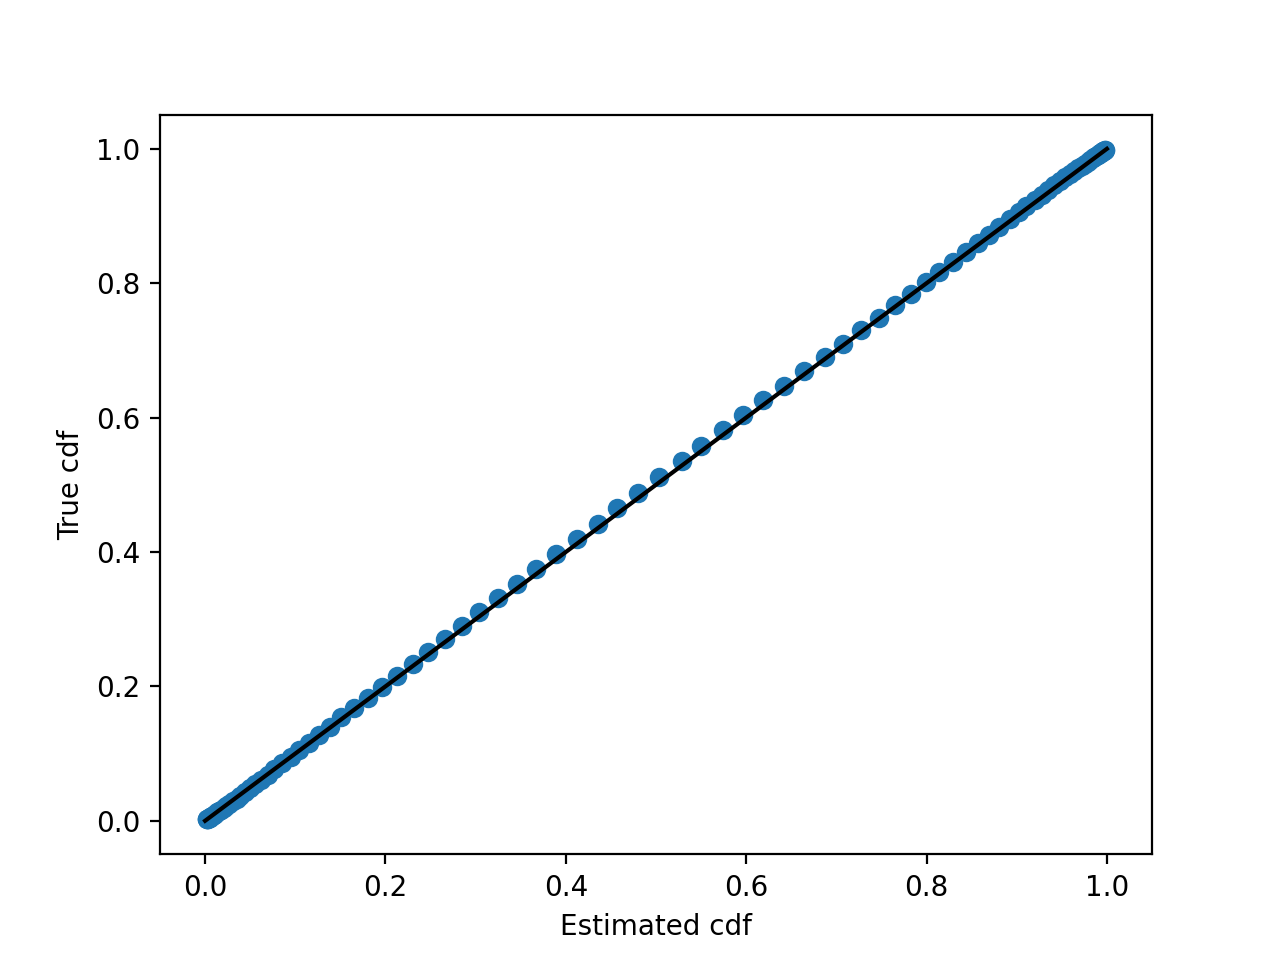

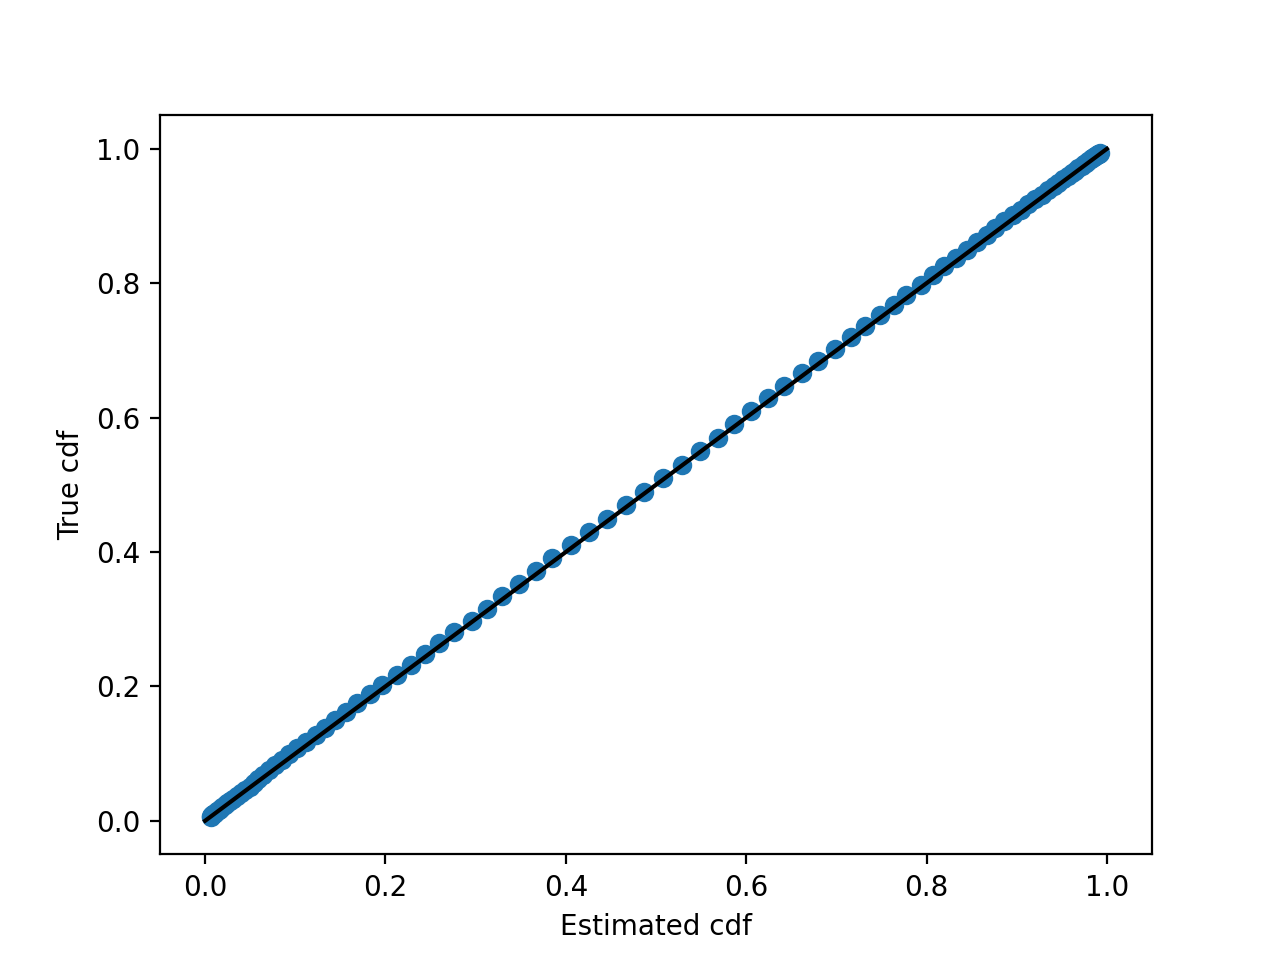

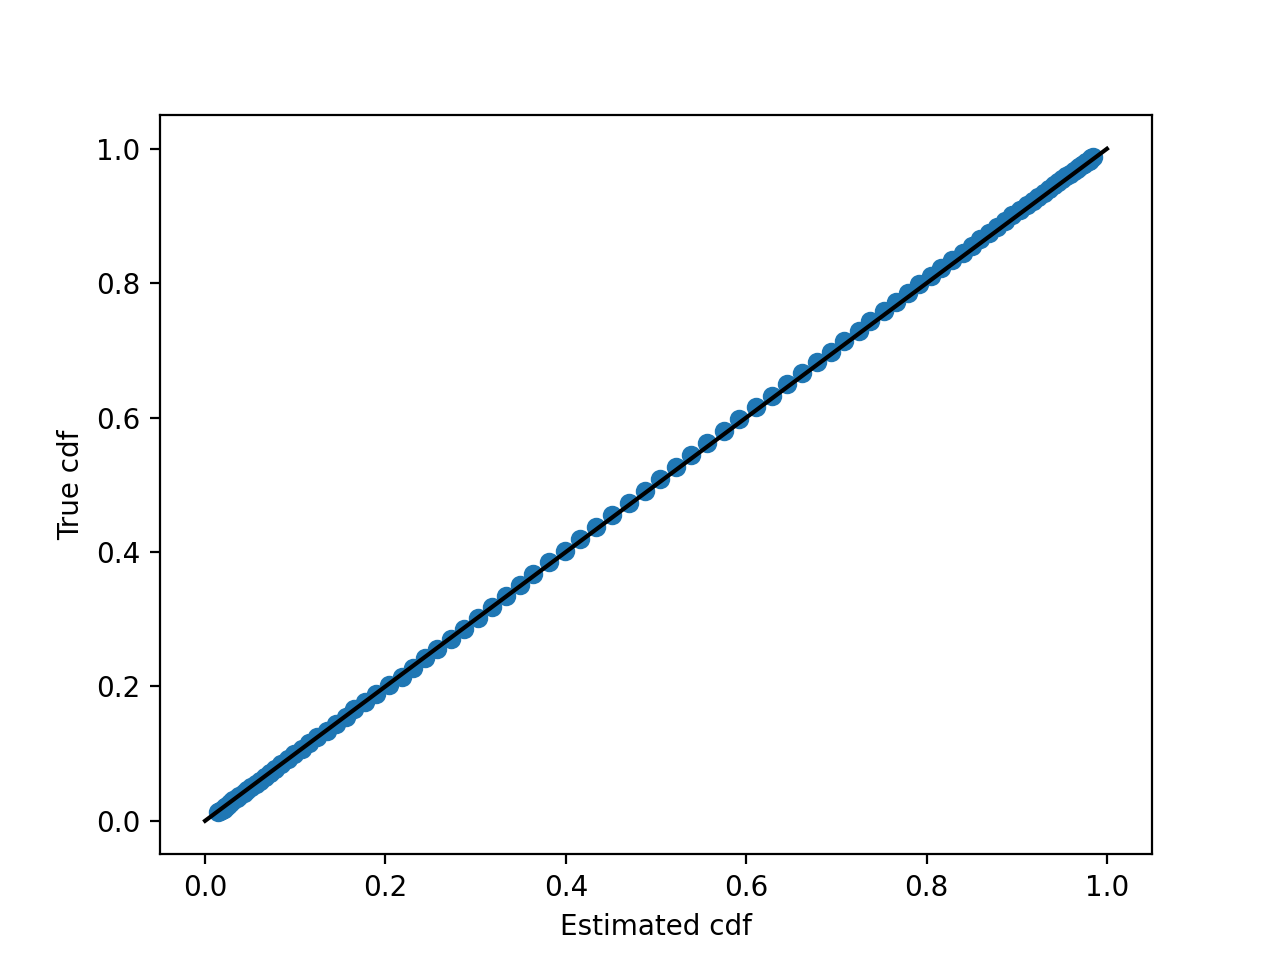

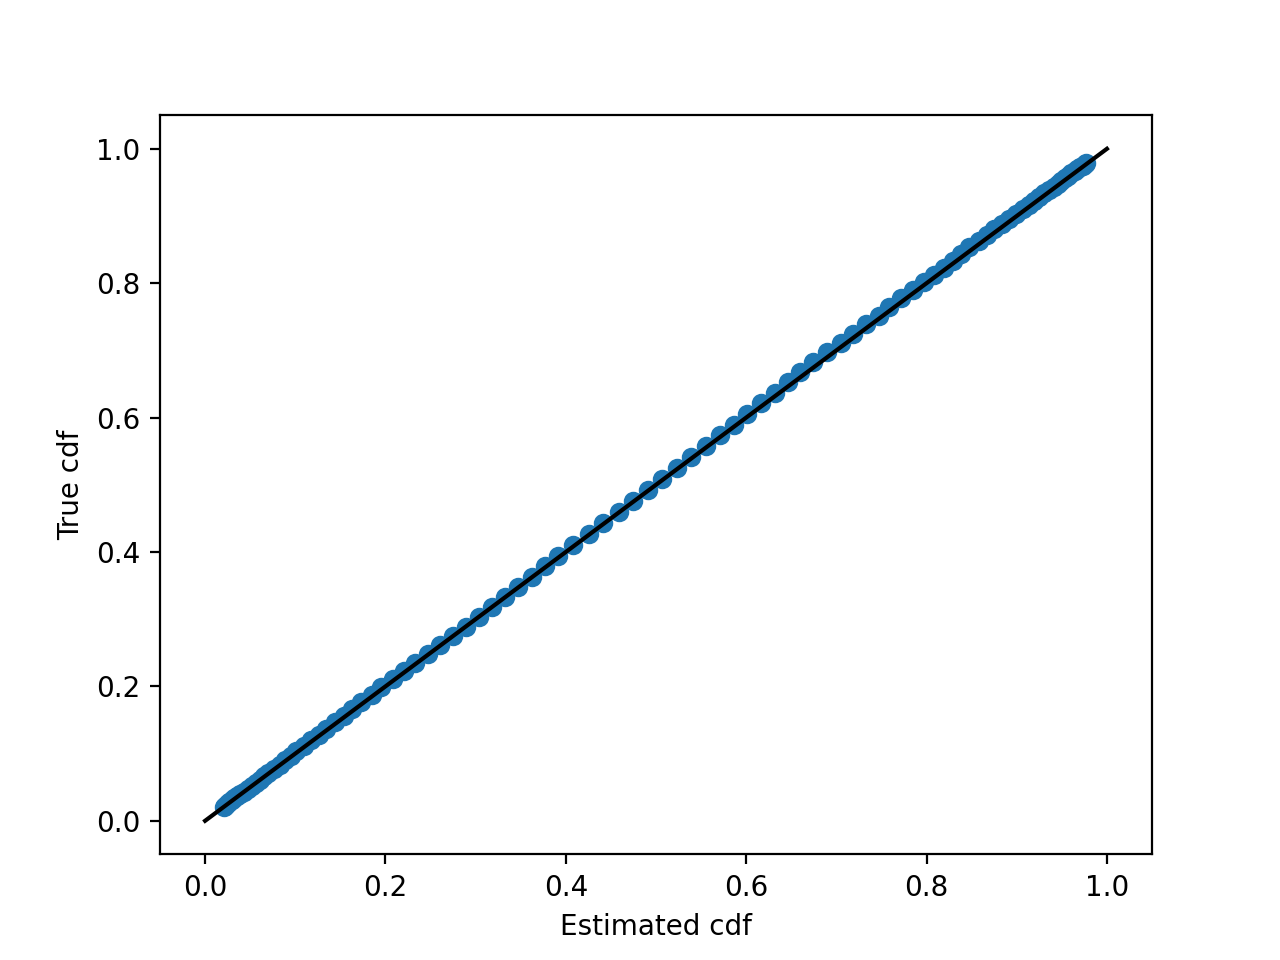

[None, None, None, None, None, None]

In [96]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

In [97]:
t = pints.Timer()
test = run_replicates(np.geomspace(3000, 10000, 8), 10, hmc.banana, parallel)
print(t.format())

8 minutes, 11 seconds


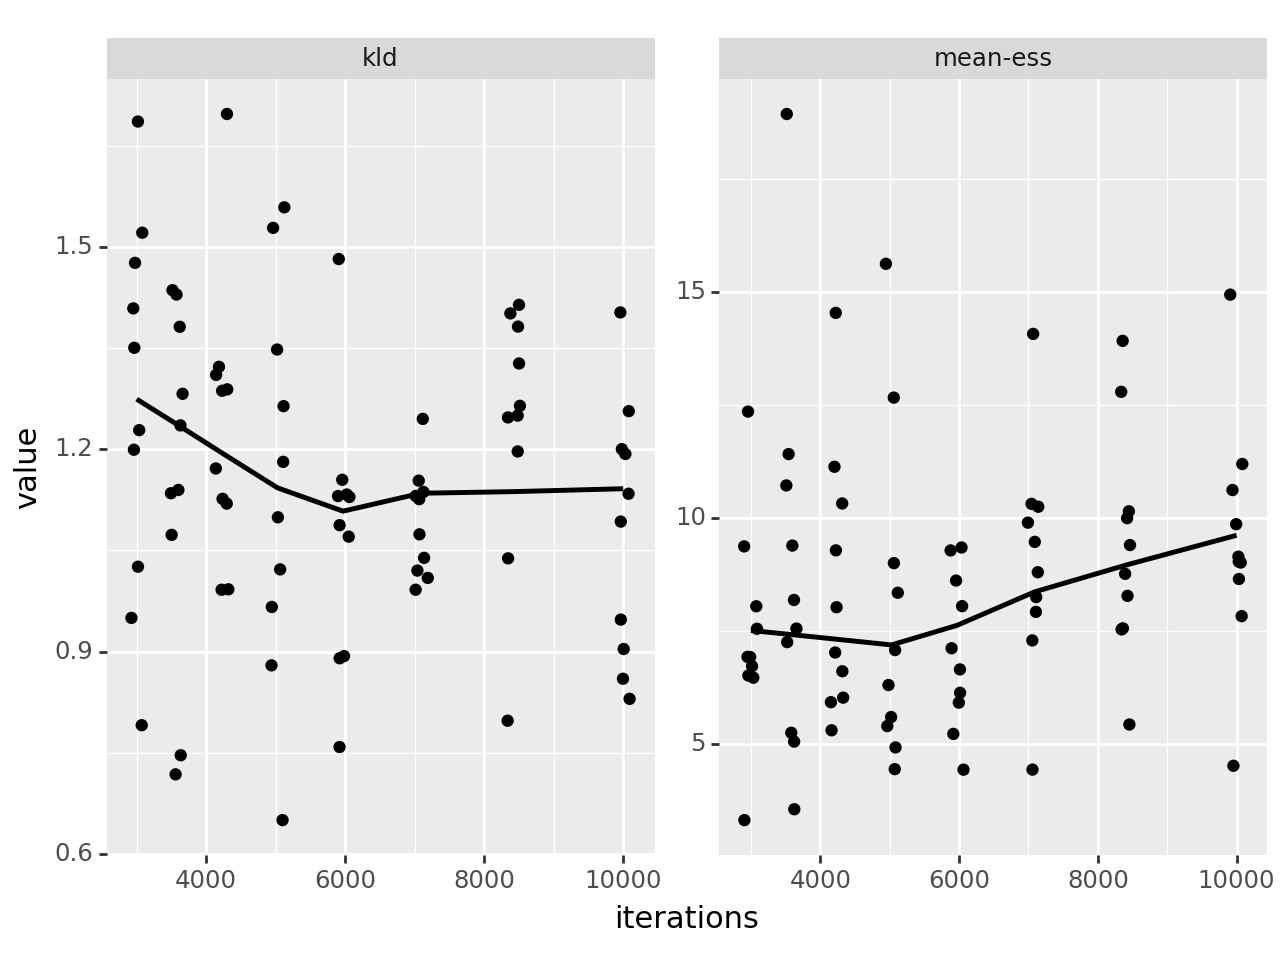

<Figure Size: (640 x 480)>

In [98]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

The banana is a hard problem with a low ESS. But the KLD is moving in the right direction.

Example run of results.

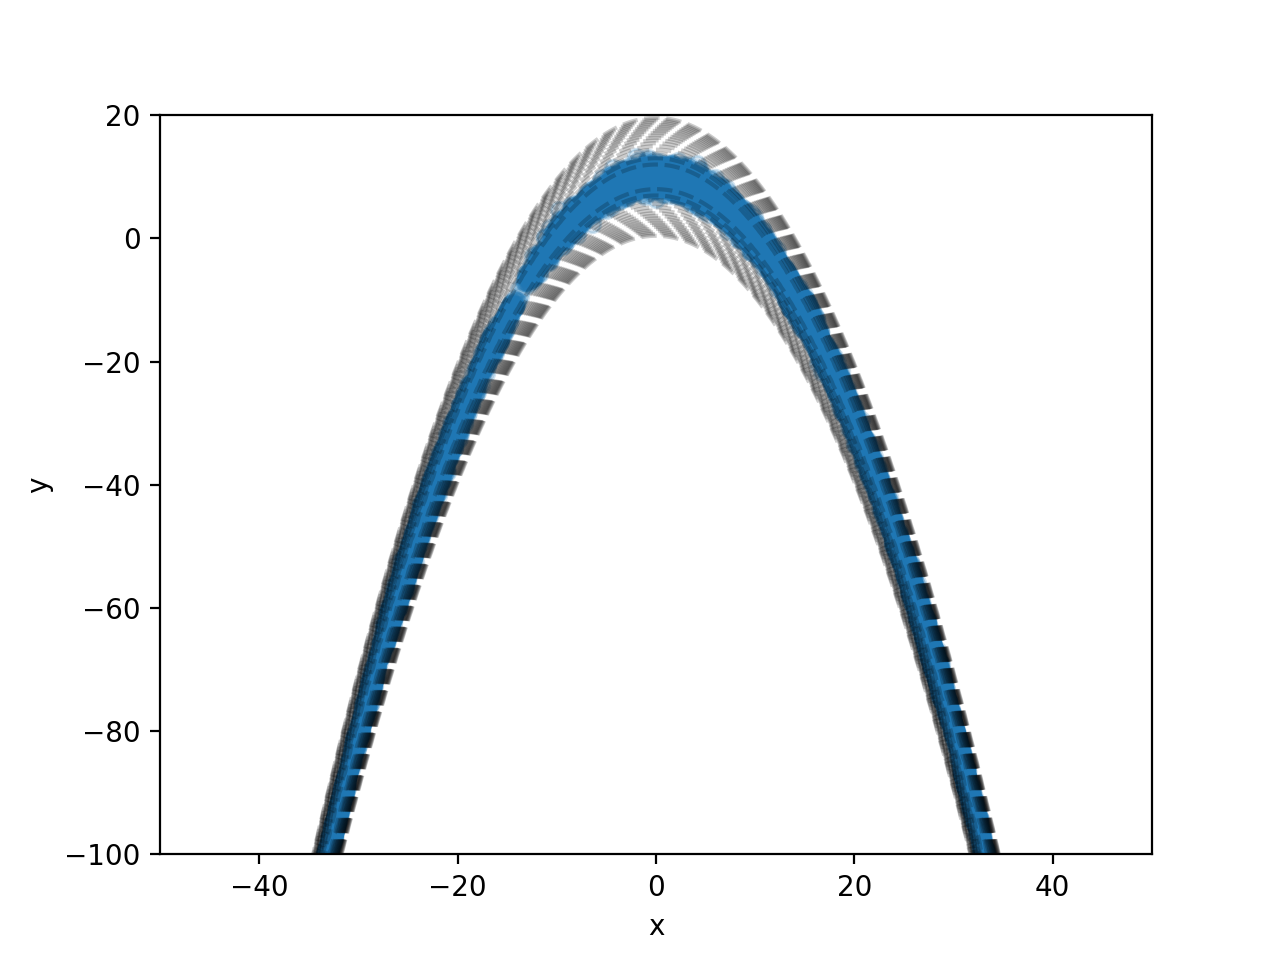

In [99]:
n_chains = 4
n_iterations = 10000
n_warmup = 3000

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(0.5)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

In [100]:
t = pints.Timer()
test = run_replicates(np.geomspace(3000, 10000, 8), 10, hmc.annulus, parallel)
print(t.format())

11 minutes, 2 seconds


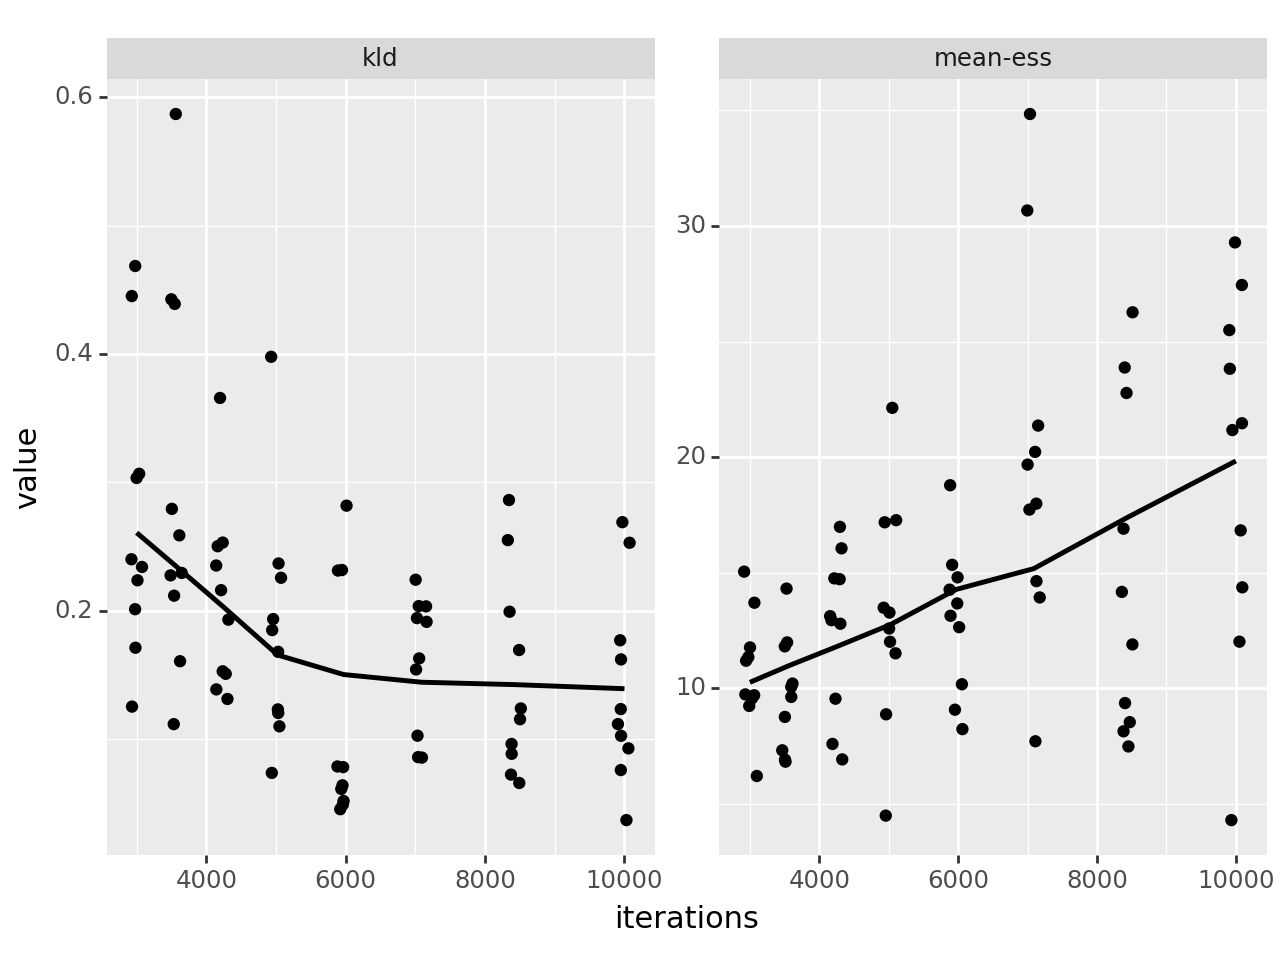

<Figure Size: (640 x 480)>

In [101]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

The draws trend closer to convergence as the number of iterations increases, although the effective sample size is low here.

Example run.

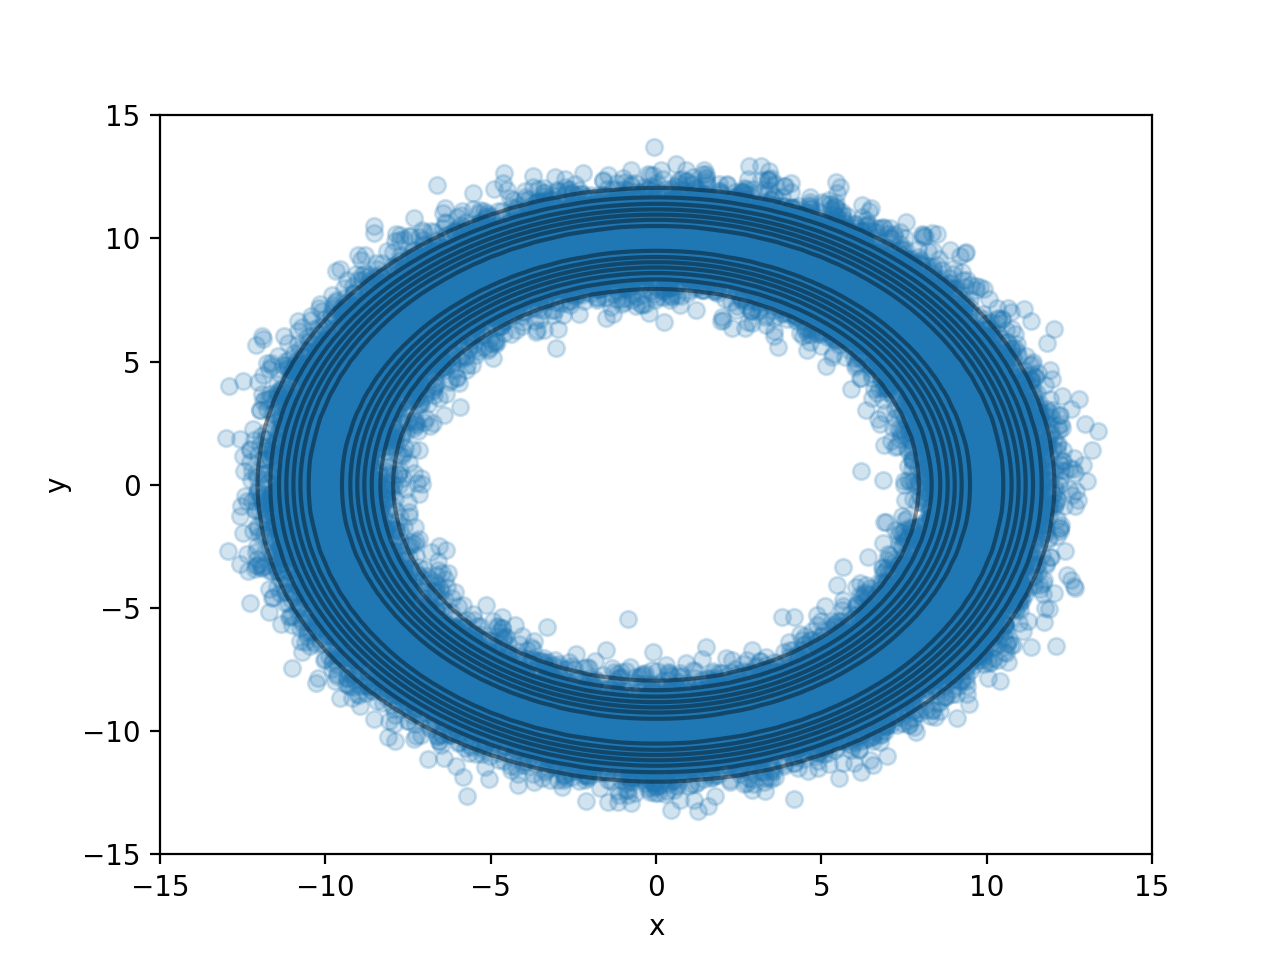

In [102]:
n_chains = 4
n_iterations = 10000
n_warmup = 2000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(0.5)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Multimodel Gaussian

In [103]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, hmc.multimodal_gaussian, parallel)
print(t.format())

8 minutes, 58 seconds


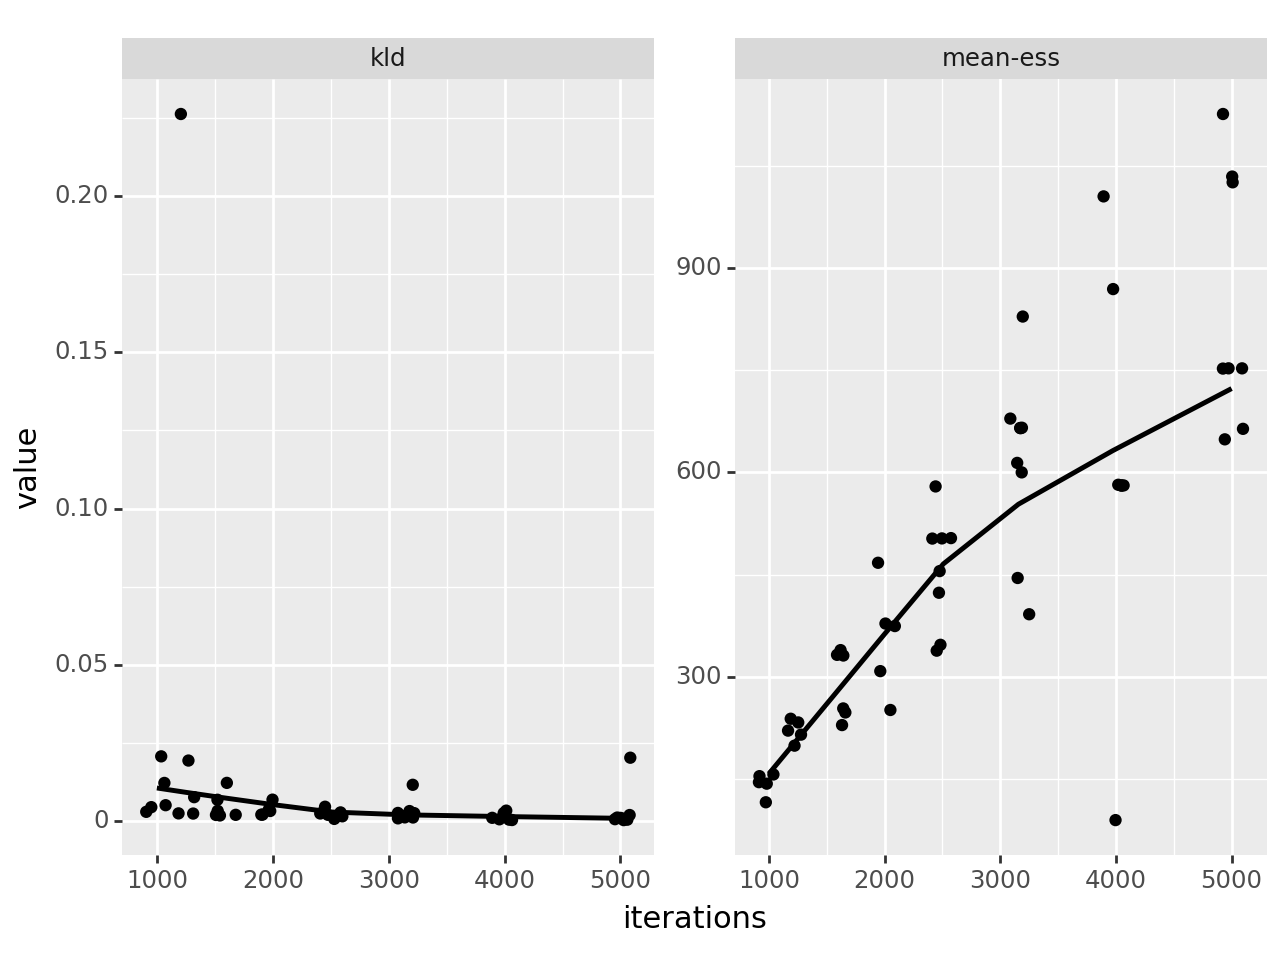

<Figure Size: (640 x 480)>

In [104]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])

# remove high values of kld to see general trend
test1 = test.query('kld < 5')
df1 = pd.melt(test1, id_vars=['iterations', 'replicate'])

(ggplot(df1, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

With the few outliers removed, the KLD appears to be moving in the correct direction as iterations increase.

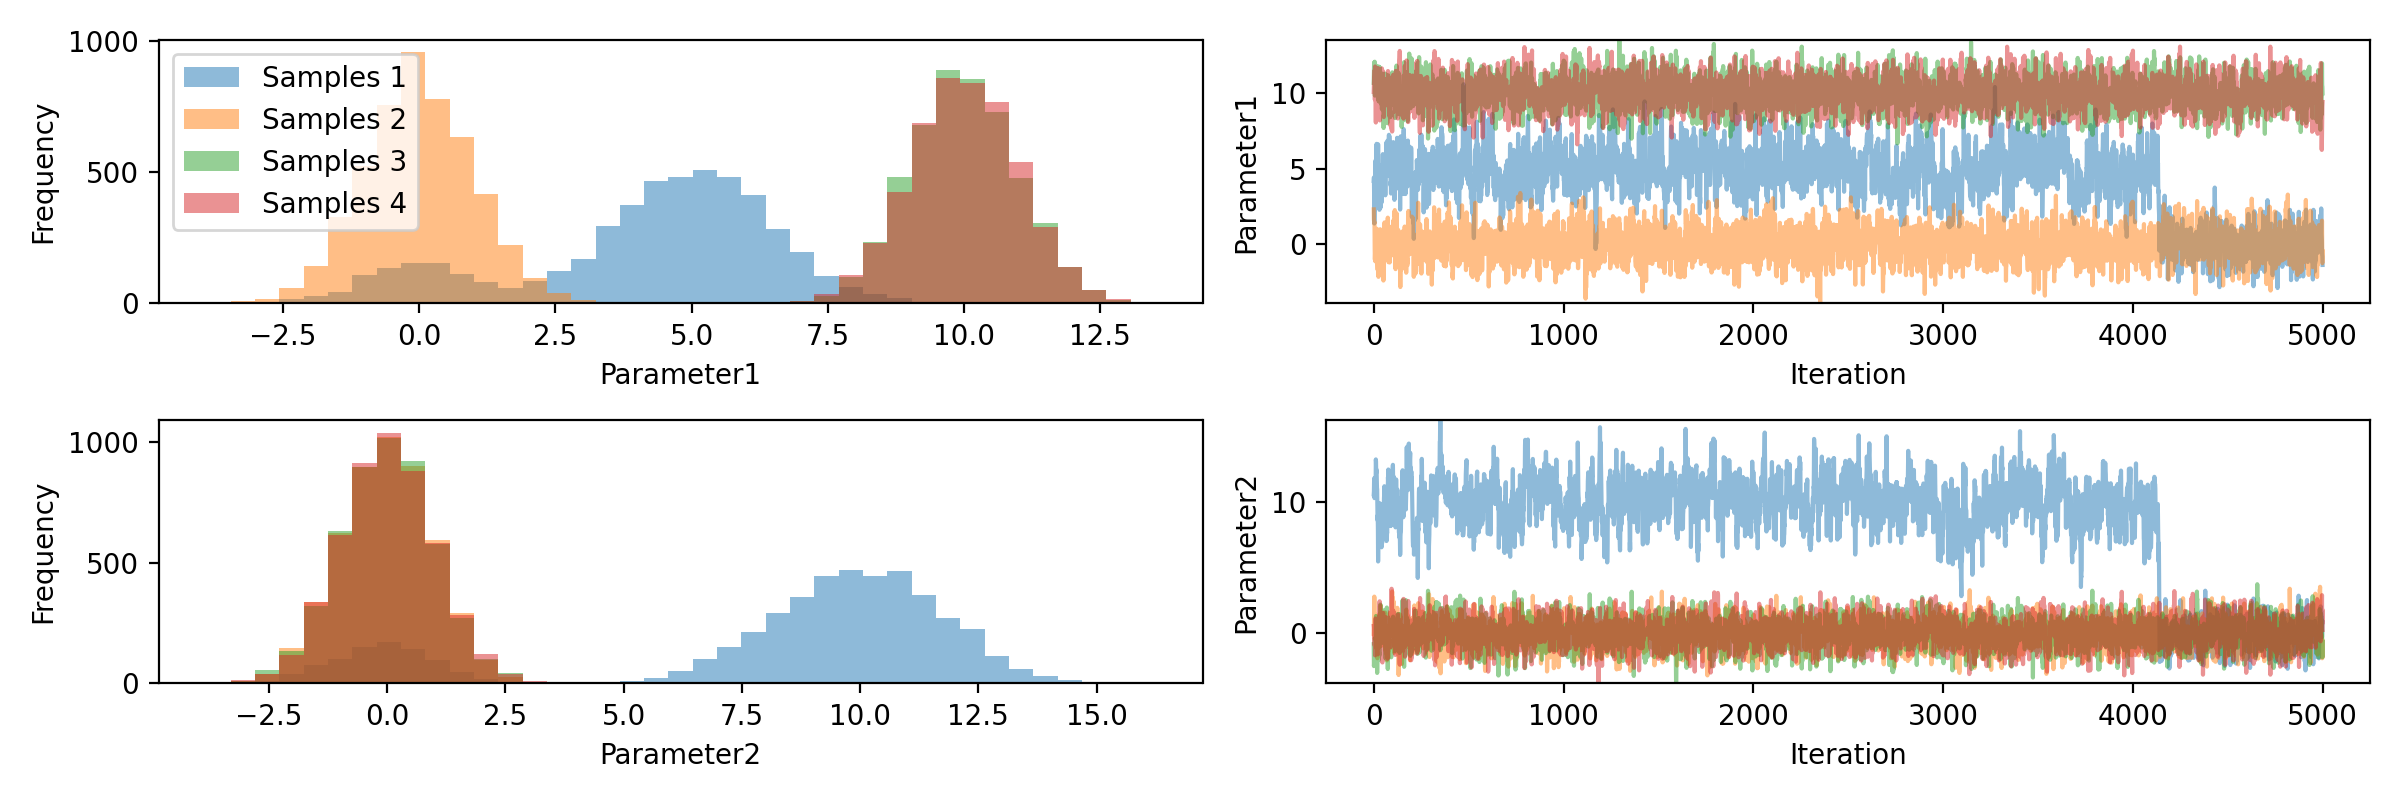

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  6.04    4.47    -1.38   1.03   7.79   10.00  11.64    3.46    2606.23  84.67
param 2  2.06    4.22    -1.86   -0.48  0.33   1.56   12.03    2.18    2568.04  83.43


In [105]:
n_chains = 4
n_iterations = 5000
n_warmup = 1000

covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]],
                                             covariances=covariances)
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(0.5)

chains = controller.run()

pints.plot.trace(chains)

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The chains can jump between the modes of the multimodel distribution.

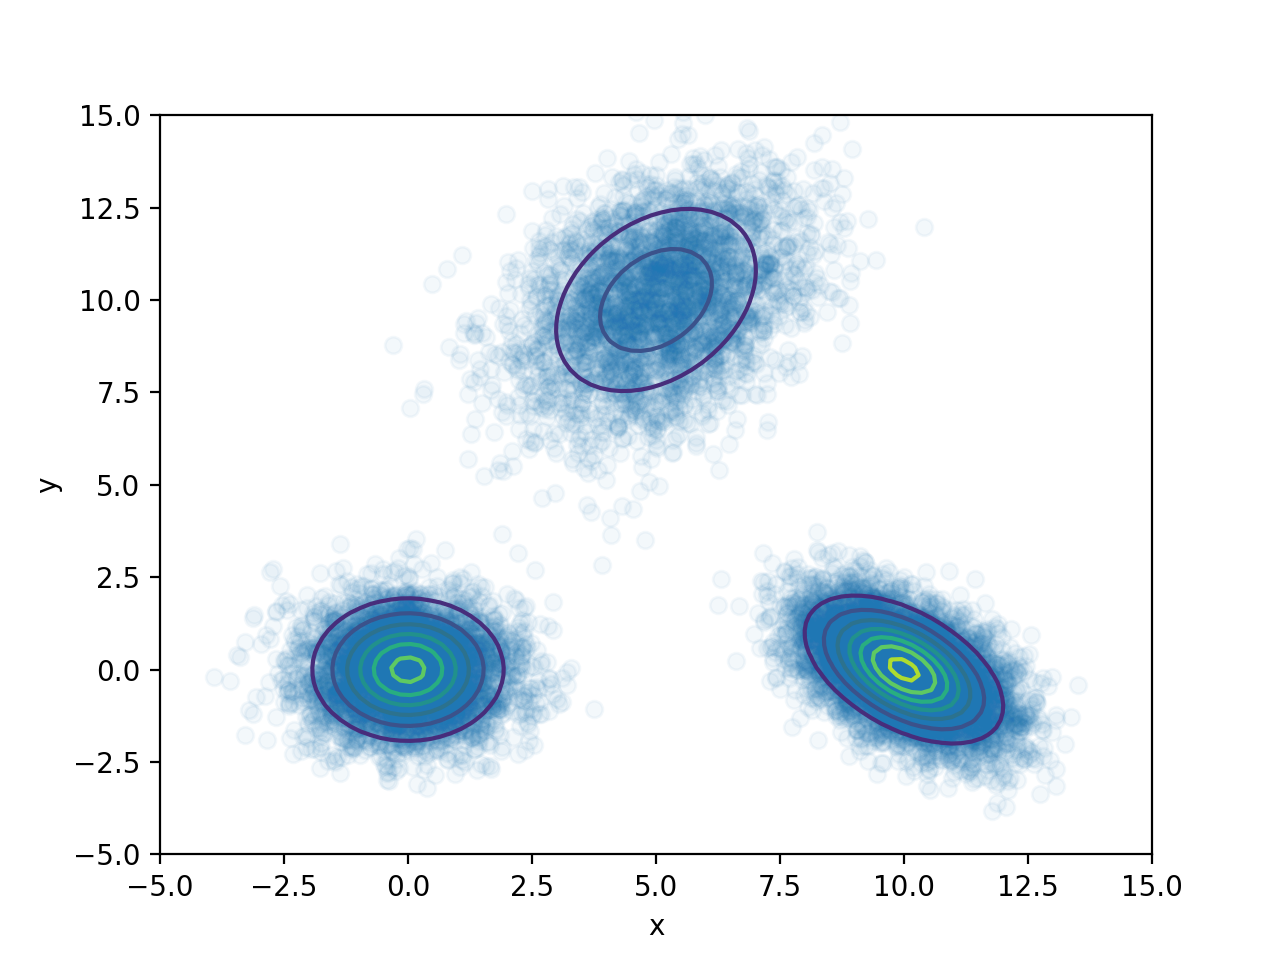

In [106]:
samples = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Cone

In [107]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, hmc.cone, parallel)
print(t.format())

1 minute, 0 seconds


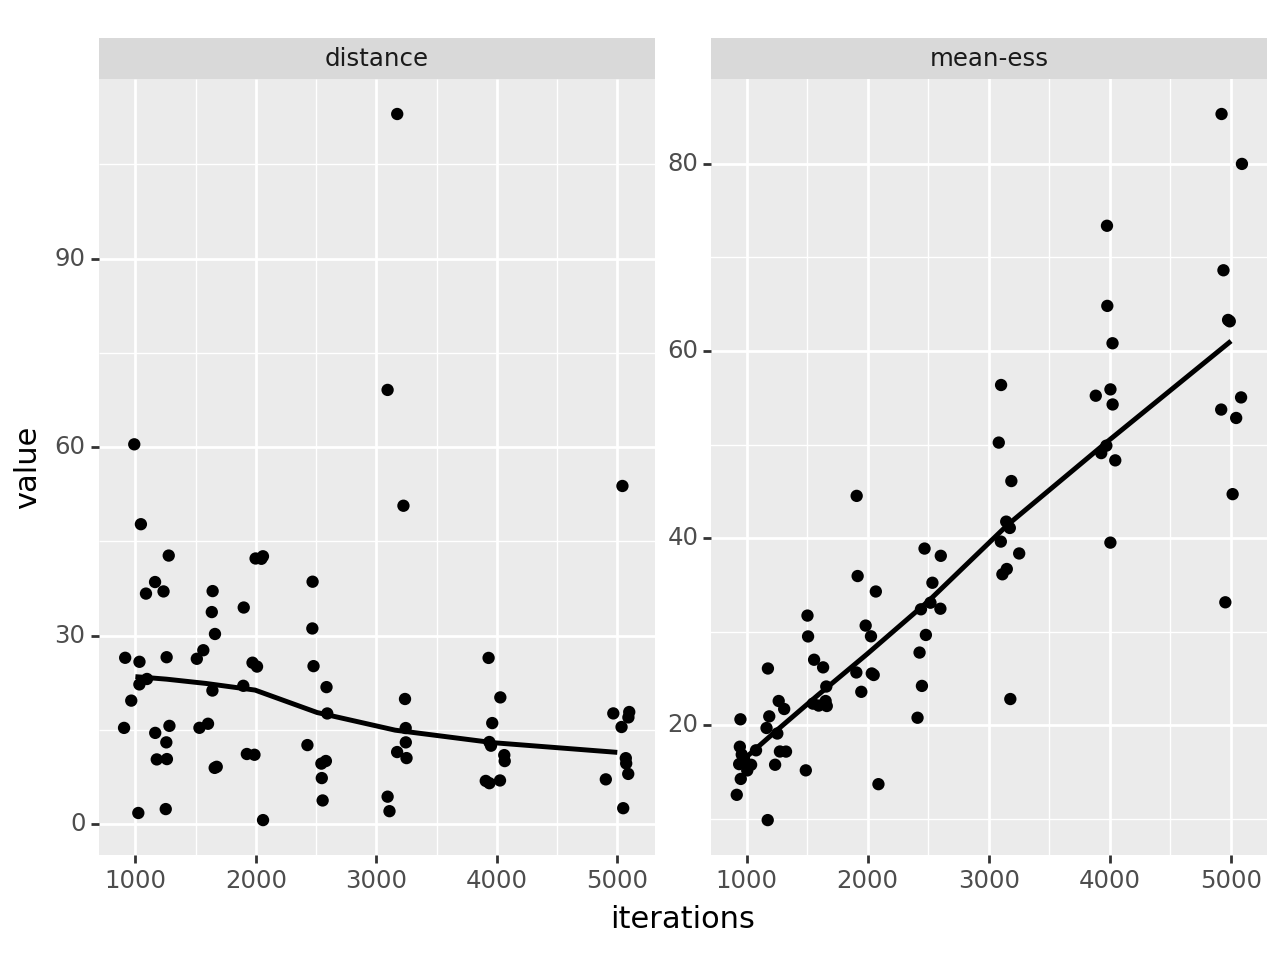

<Figure Size: (640 x 480)>

In [108]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

The cone problem, with its long tails, is really hard.

An example run.

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.5        0:00.0
3     244    0.6       0.6       0.6       0.6        0:00.0
20    1604   0.909     0.909     0.909     0.909      0:00.0
40    3204   0.952381  0.952381  0.952381  0.952381   0:00.1
60    4804   0.968     0.968     0.968     0.968      0:00.1
80    6404   0.976     0.976     0.976     0.976      0:00.1
100   8004   0.98      0.98      0.98      0.98       0:00.1
120   9604   0.984     0.984     0.984     0.984      0:00.1
140   11204  0.986     0.986     0.986     0.986      0:00.1
160   12804  0.988     0.988     0.988     0.988      0:00.2
180   14404  0.989011  0.989011  0.989011  0.989011   0:00.2
200   16004  0.990099  0.990099  0.990099  0.990099   0:

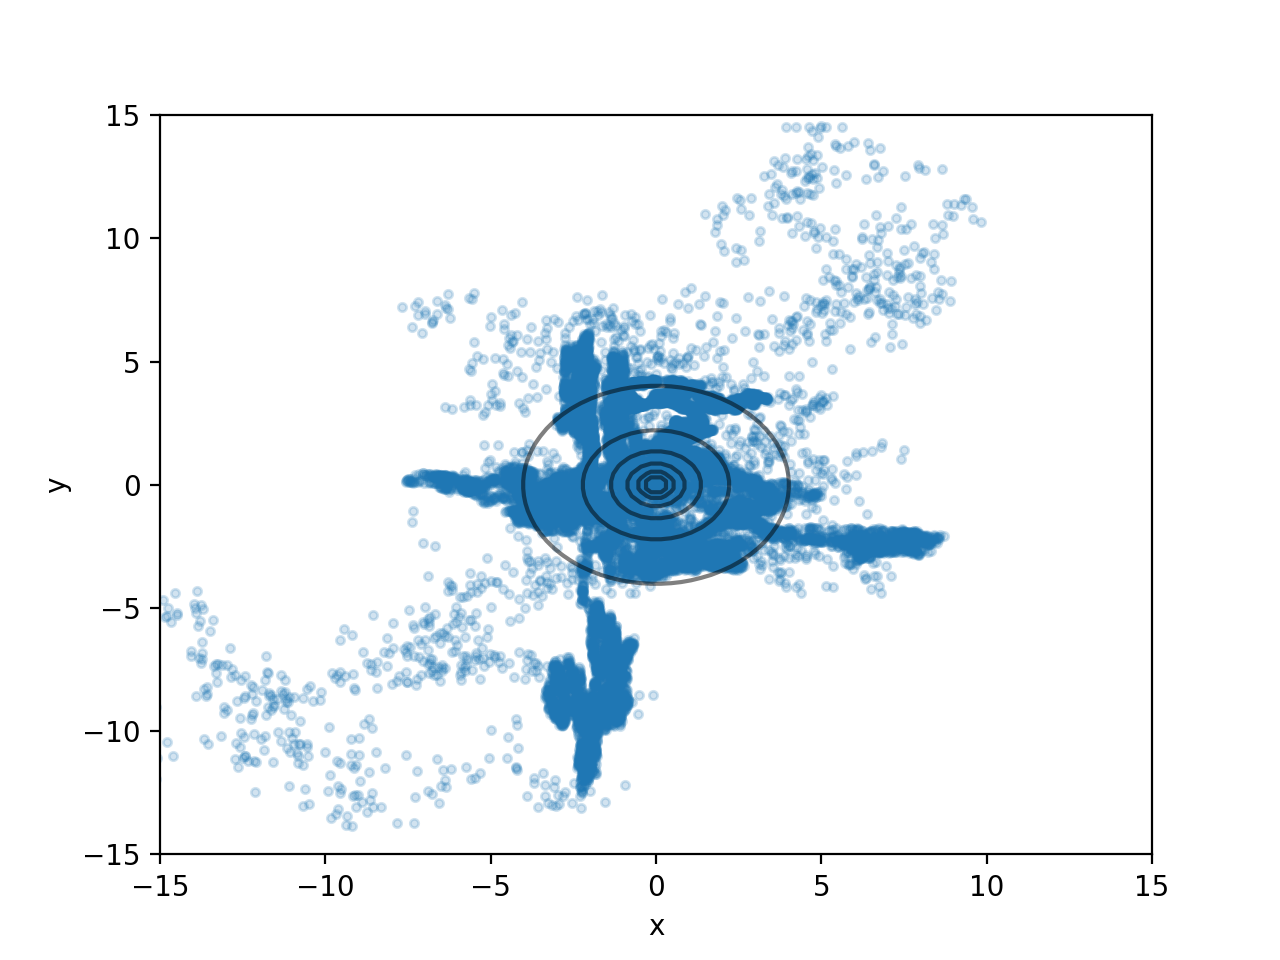

True normed mean = 8.638816024714002
Sample normed mean = 10.632282966339412
True normed var = 65.40423915068341
Sample normed var = 214.21055332244453


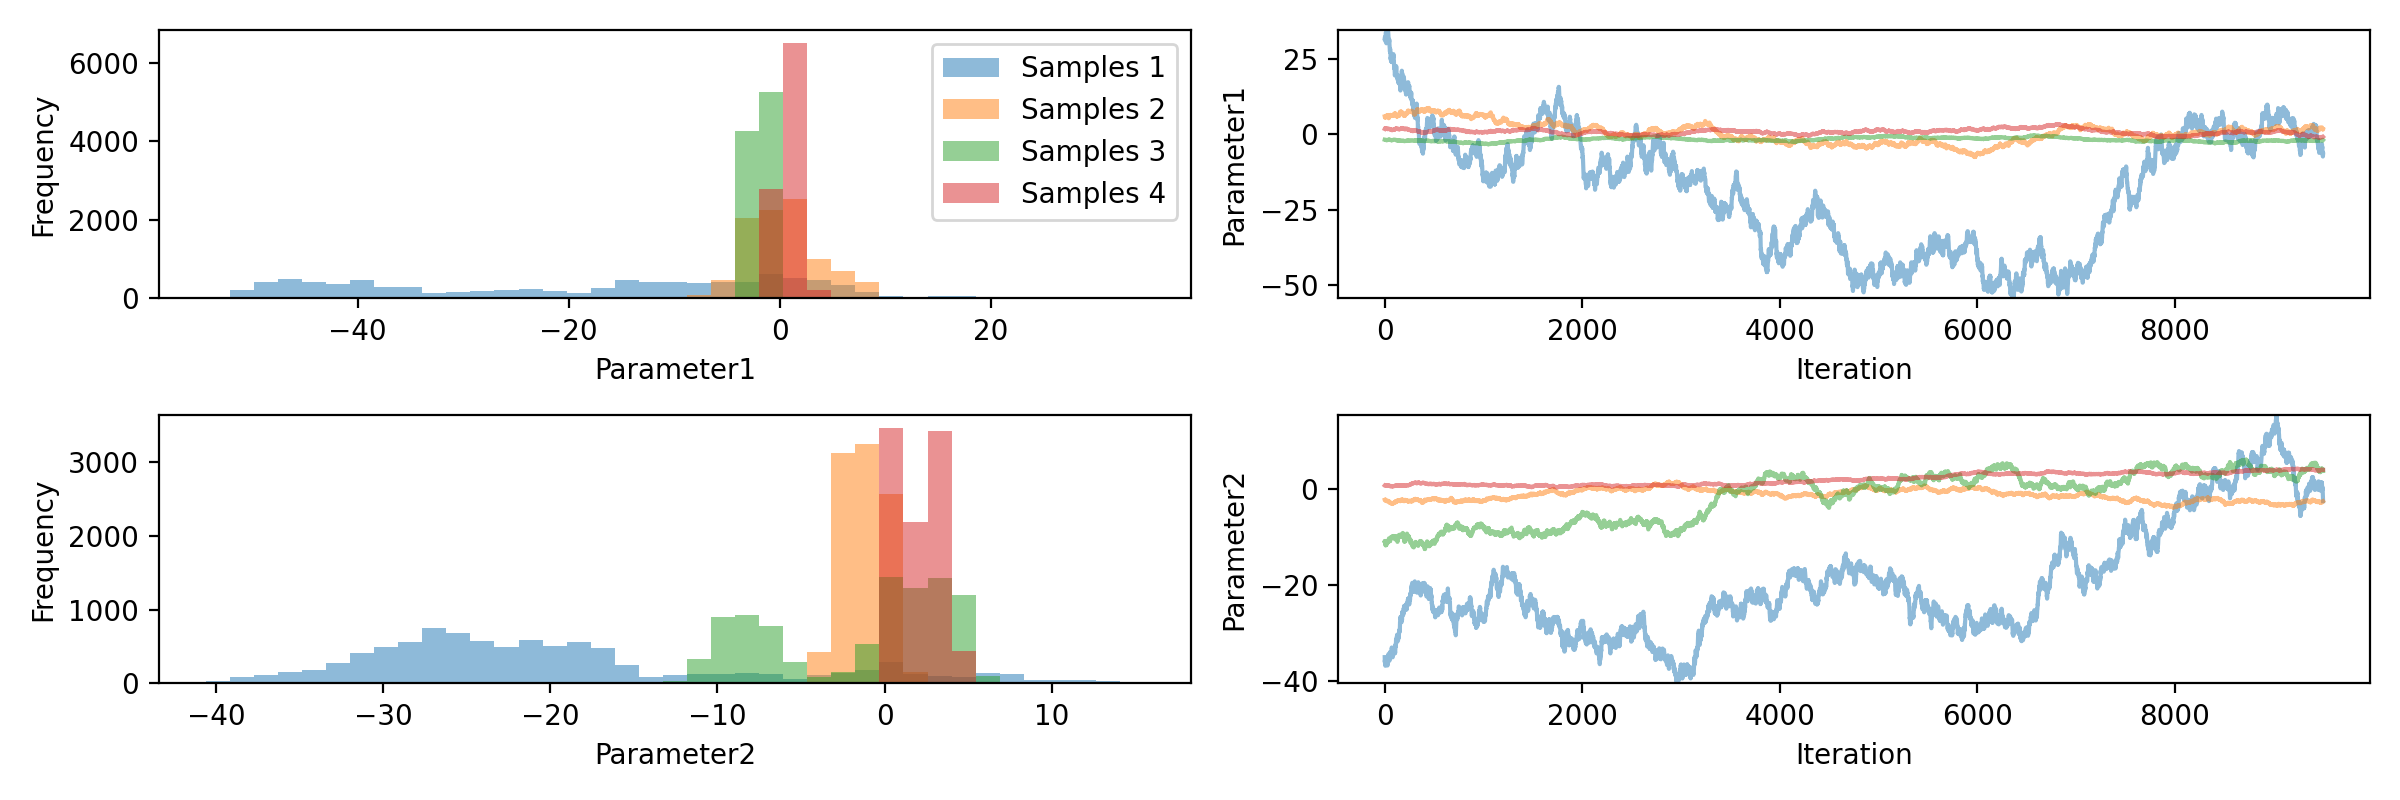

In [109]:
nchains = 4
log_pdf = pints.toy.ConeLogPDF(dimensions=2, beta=0.6)
x0 = log_pdf.sample(nchains)
mcmc = pints.MCMCController(log_pdf, nchains, x0, method=pints.HamiltonianMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(10000)

# Disable logging
mcmc.set_log_to_screen(True)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(0.3)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),
                            parameter_names=['mean dim 1', 'mean dim 2'])
print(results)

# Discard warm-up
chains = [chain[500:] for chain in chains]
stacked = np.vstack(chains)

# overlay draws on contours
num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

d = list(map(lambda x: np.linalg.norm(x), stacked))
a_mean = np.mean(d)
a_var = np.var(d)

print("True normed mean = " + str(log_pdf.mean_normed()))
print("Sample normed mean = " + str(a_mean))

print("True normed var = " + str(log_pdf.var_normed()))
print("Sample normed var = " + str(a_var))

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# High dimensional Gaussian

In [110]:
t = pints.Timer()
test = run_replicates(np.geomspace(3000, 7000, 8), 10, hmc.high_dim_gaussian, parallel)
print(t.format())

4 minutes, 3 seconds


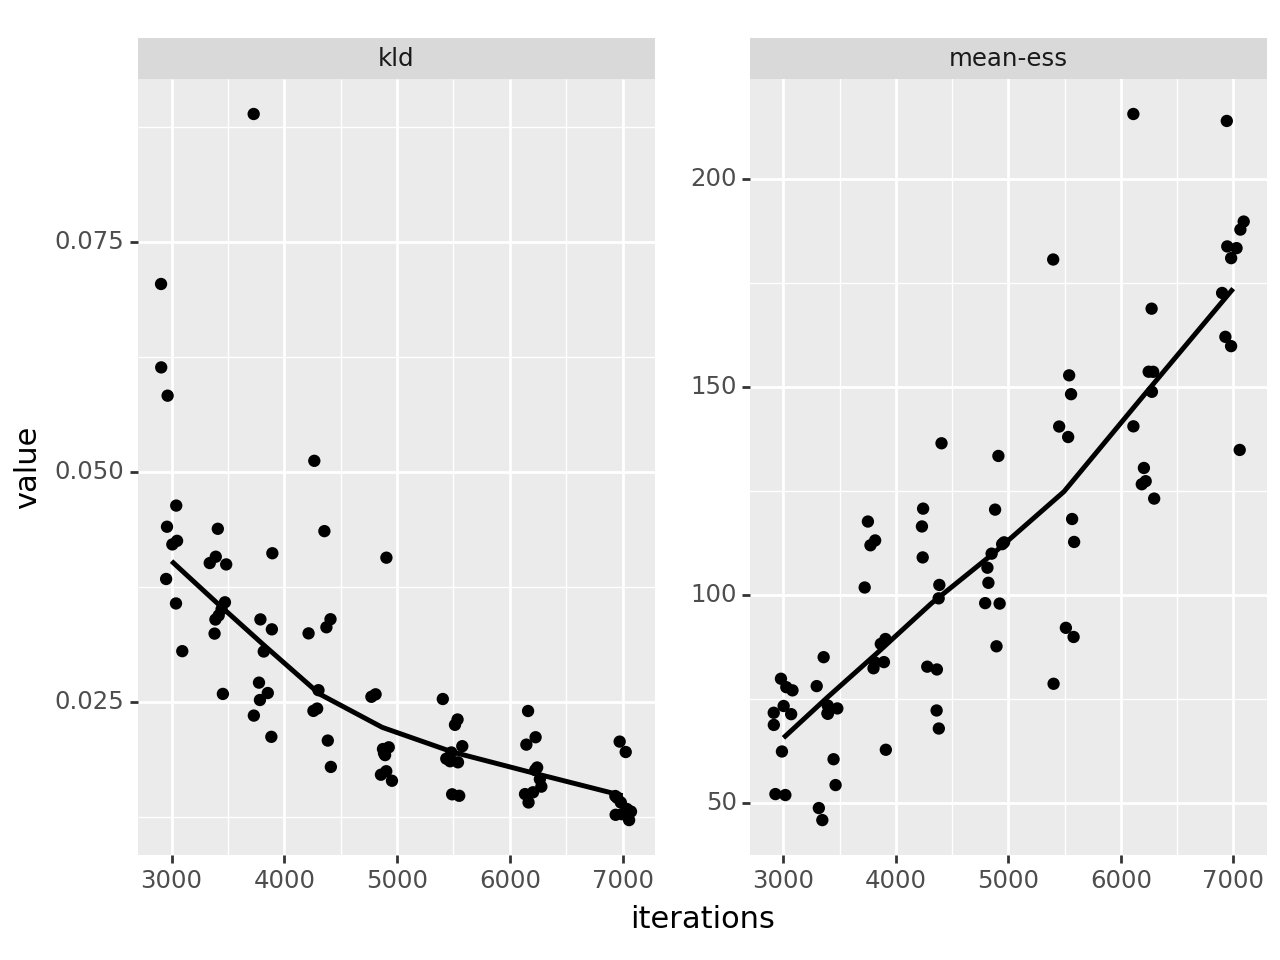

<Figure Size: (640 x 480)>

In [111]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)